In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

import xgboost as xgb
import pickle

In [2]:
profile = pd.read_csv("data/profile.csv")
portfolio = pd.read_csv("data/portfolio-dummy.csv")
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")
train_transactions = pd.read_csv("data/train_transactions.csv")
test_transactions = pd.read_csv("data/test_transactions.csv")

In [3]:
def encode_dataset(df, transactions, shuffle=False):
    df = df.merge(profile, left_on='person', right_on='id') \
        .merge(portfolio, left_on='offer_id', right_on="id") \
        .merge(transactions, left_on='person', right_on='person')
    if shuffle:
        df = df.sample(frac=1)
    df.index = df[['person', 'offer_id']]
    
    y = df['offer viewed']
    df = df.drop(columns=['person', 'offer_id', 'id_x', 'id_y', 'index', 'offer viewed'])
    return df, y

X_train, y_train = encode_dataset(train_set, train_transactions, True)
X_test, y_test = encode_dataset(test_set, test_transactions, False)

In [4]:
# y_train.mean()
# y_test.mean()
# X_train.head()
y_train

(b69d33d582fa4ffbbe9f1fd022f24463, 5a8bc65990b245e5a138643cd4eb9837)    1.0
(b27ee195759a4d16a2f503c3ae3d40ae, 2906b810c7d4411798c6938adc9daaa5)    1.0
(964c98dc94fb4887a6843cafa5041dd7, 4d5c57ea9a6940dd891ad53e9dbe8da0)    1.0
(9a51d710fdda4b4ebba9550dcd15353c, 3f207df678b143eea3cee63160fa8bed)    1.0
(d122a4332290450fbecdca2d5e15ee0d, 3f207df678b143eea3cee63160fa8bed)    0.0
                                                                       ... 
(07bdb81f215b4ef19653675c6eb2c447, 5a8bc65990b245e5a138643cd4eb9837)    0.0
(9da20f64522348e7a8d5006fc232b2b6, 2298d6c36e964ae4a3e7e9706d1fb8c2)    1.0
(03e67807671e4cb4bb34f2ebabc97d28, 2298d6c36e964ae4a3e7e9706d1fb8c2)    1.0
(ef4ba06a65bb4dd19abc8dcb53b70a49, 2298d6c36e964ae4a3e7e9706d1fb8c2)    1.0
(6579197d0b2f491db0ccf26c74b9b311, 4d5c57ea9a6940dd891ad53e9dbe8da0)    1.0
Name: offer viewed, Length: 42953, dtype: float64

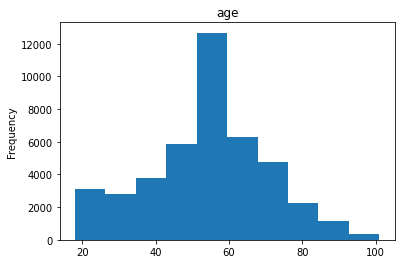

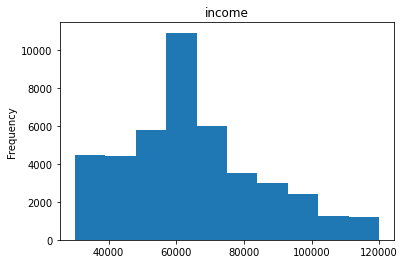

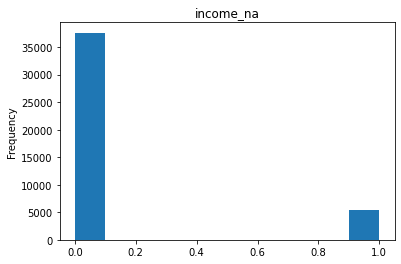

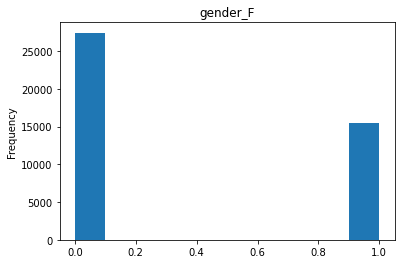

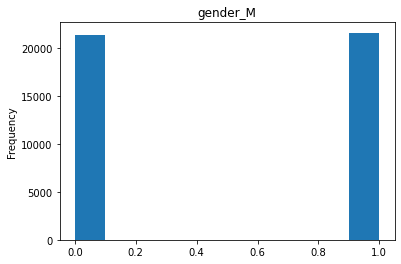

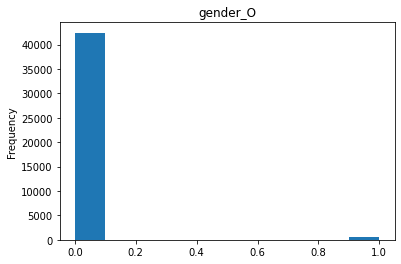

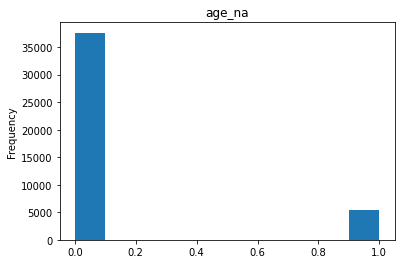

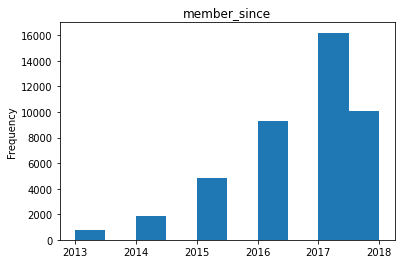

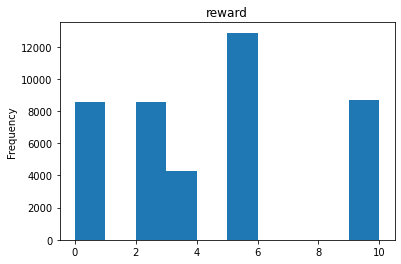

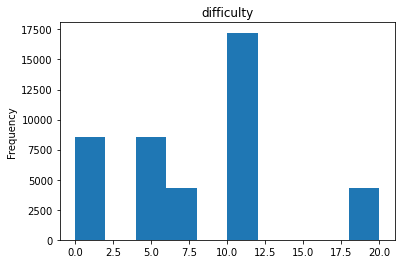

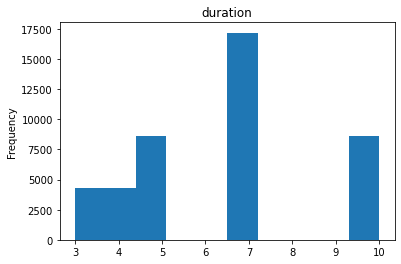

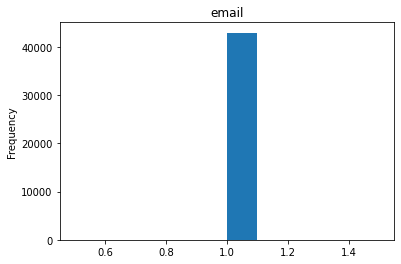

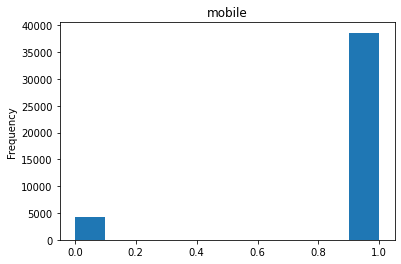

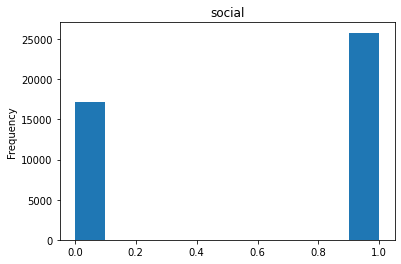

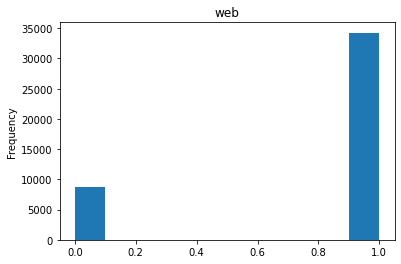

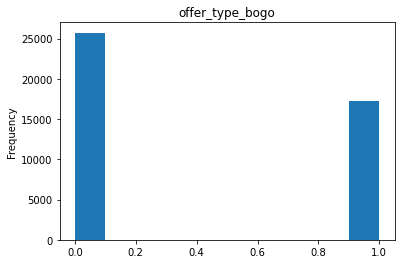

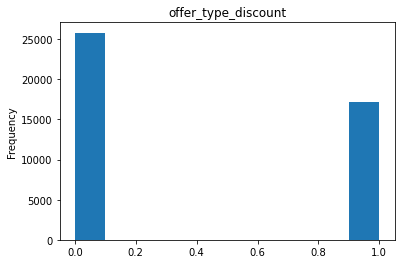

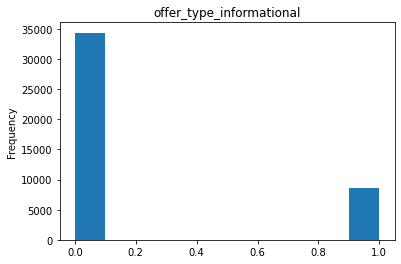

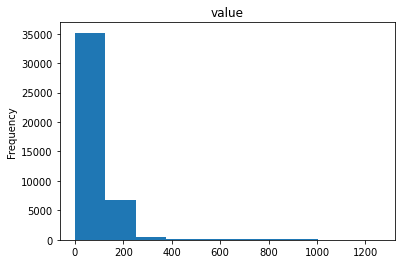

In [5]:

def show_df_dist(df):
    for c in df.columns:
        df[c].plot.hist(title=c)
        plt.show()

show_df_dist(X_train)

In [6]:
def get_xgb():
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('xgb', xgb.XGBClassifier(
                silent=False,
                objective='binary:logistic',
                booster='gbtree'
            ))
        ],
        verbose = True
    )
    
    return pipe

def get_xgb_gcv():
    
    param_grid = {
        'xgb__booster' :['gbtree'],
        'xgb__silent':[False],
        'xgb__max_depth':[5,6,8],
        'xgb__min_child_weight':[1,3,5],
        'xgb__gamma':[0,1,2,3],
        'xgb__nthread':[4],
        'xgb__colsample_bytree':[0.5,0.8],
        'xgb__colsample_bylevel':[0.9],
        'xgb__n_estimators':[50],
        'xgb__objective':['binary:logistic'],
        'xgb__random_state':[2]
    }
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('xgb', xgb.XGBClassifier())
        ],
        verbose = True
    )
    gcv=GridSearchCV(pipe, param_grid=param_grid, scoring='f1', n_jobs=1, verbose=1)
    
    return gcv

In [7]:
def train_and_test(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print("Report for", name)
    print("Train Report>")
    print("Train Accuracy:", model.score(X_train, y_train))
    y_pred = model.predict(X_train)
    print(classification_report(y_train, y_pred))
    
    print("Test Report>")
    print("Test Accuracy:", model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [8]:
model = get_xgb_gcv()

In [9]:
%%time
train_and_test("xgb-gcv", model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[22:16:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   2.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:16:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ........

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:16:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:16:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:17:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:18:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   1.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:19:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:20:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:21:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:21:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:21:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[22:21:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificati

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.7min finished


[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.6s
Report for xgb-gcv
Train Report>
Train Accuracy: 0.9052222108480426
              precision    recall  f1-score   support

         0.0       0.72      0.56      0.63      9886
         1.0       0.88      0.94      0.91     33067

    accuracy                           0.85     42953
   macro avg       0.80      0.75      0.77     42953
weighted avg       0.84      0.85      0.84     42953

Test Report>
Test Accuracy: 0.8919141428991473
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64      5362
         1.0       0.88      0.90      0.89     16808

    accuracy                           0.83     22170
   macro avg       0.78      0.76      0.77     22170
weighted avg       0.83      0.83      0.83     22170

Wall time: 4min 40s


In [34]:
with open("model/xgb_gcv2.pkl", "wb") as f:
    pickle.dump(model, f)

In [9]:
with open("model/xgb_gcv2.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
%%time
non_opt_model = get_xgb()
train_and_test("xgb", non_opt_model, X_train, y_train, X_test, y_test)

In [13]:

def get_1(X, y_true, y_pred, true_val, pred_val):
    return X.loc[y_pred[(y_true == true_val) & (y_pred == pred_val)].index]

def get_error(model, X, y):
    y_true = y
    y_pred = pd.Series(model.predict(X), index=y.index)
    
    tp = get_1(X, y_true, y_pred, 1, 1)
    tn = get_1(X, y_true, y_pred, 1, 0)
    fp = get_1(X, y_true, y_pred, 0, 1)
    fn = get_1(X, y_true, y_pred, 0, 0)
    
    return tp, tn, fp, fn

In [14]:
test_tp, test_tn, test_fp, test_fn = get_error(model, X_test, y_test)

In [15]:
corrects = pd.concat([test_tp, test_fn], axis=0)
wrongs = pd.concat([test_tn, test_fp], axis=0)

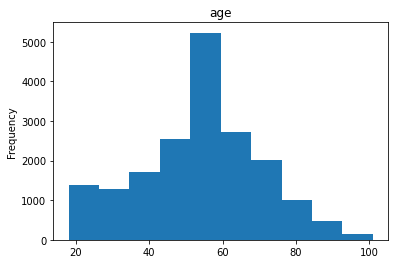

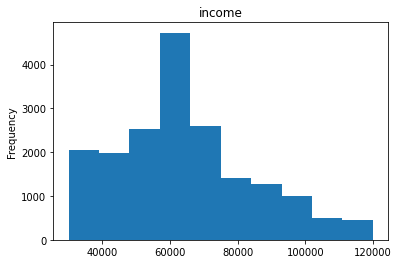

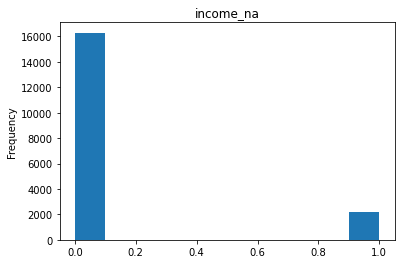

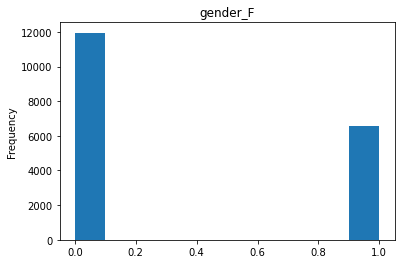

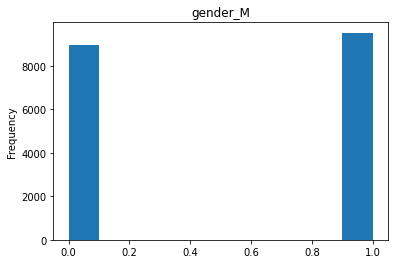

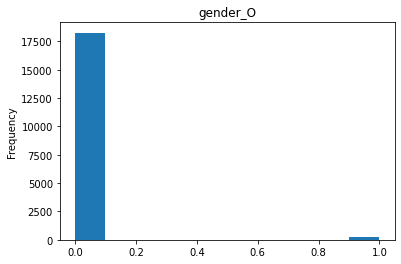

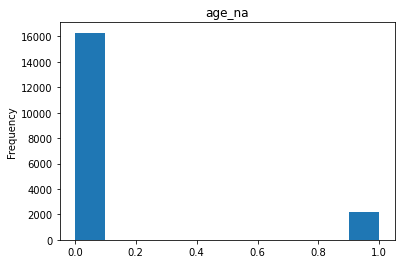

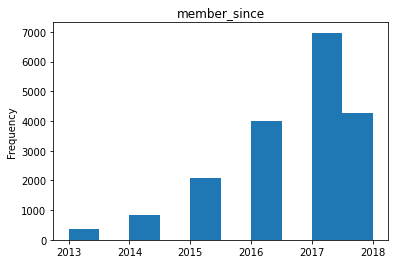

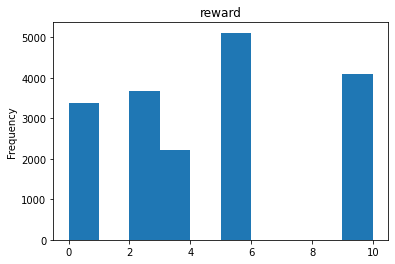

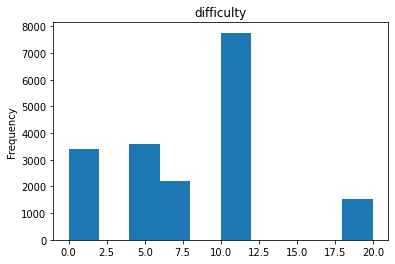

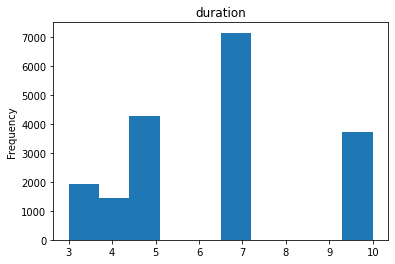

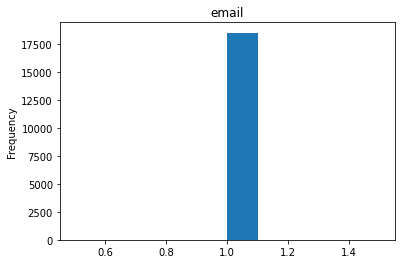

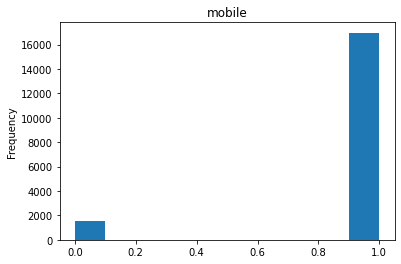

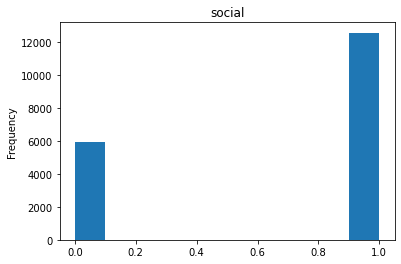

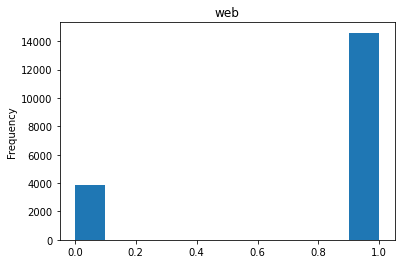

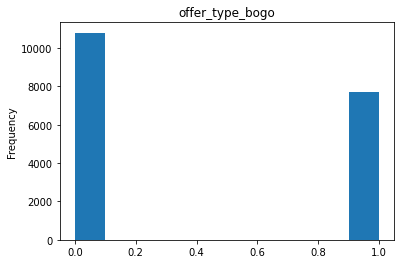

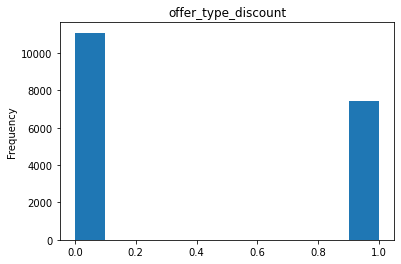

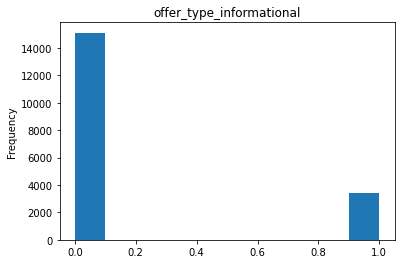

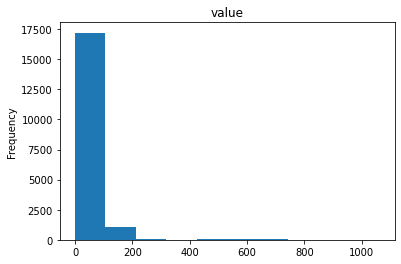

In [16]:
show_df_dist(corrects)

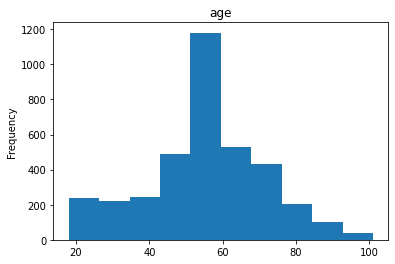

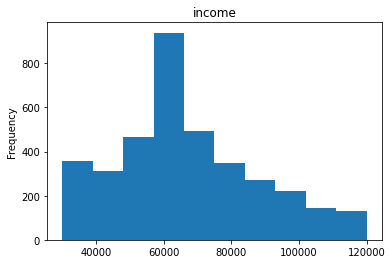

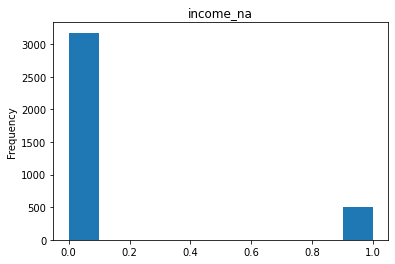

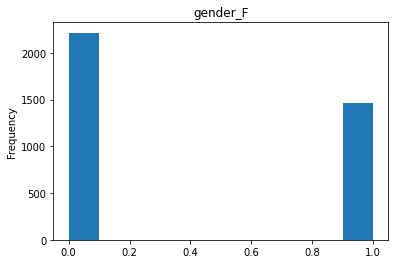

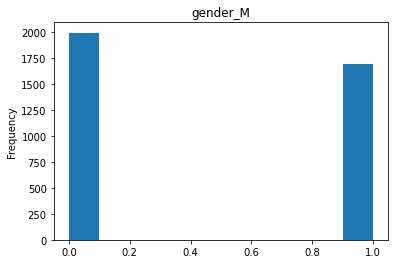

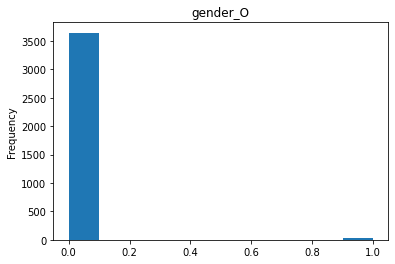

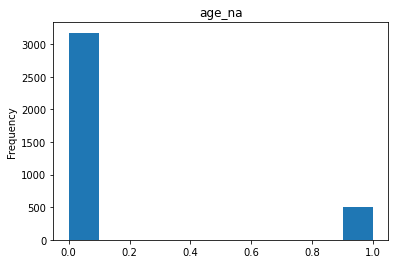

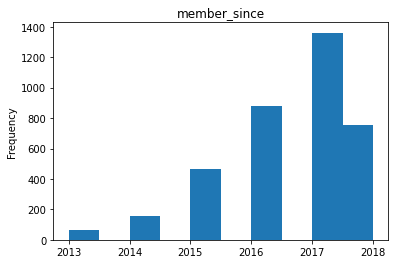

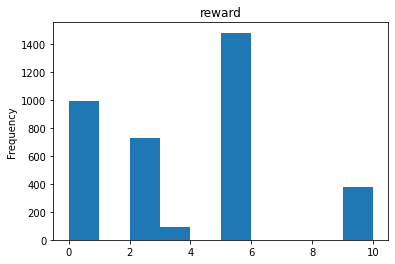

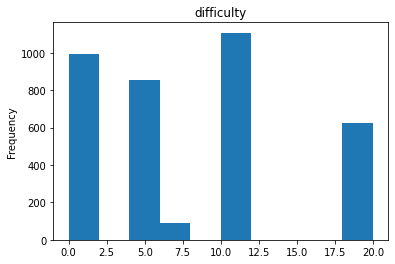

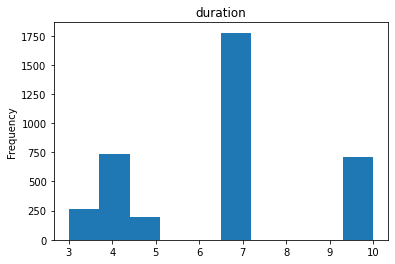

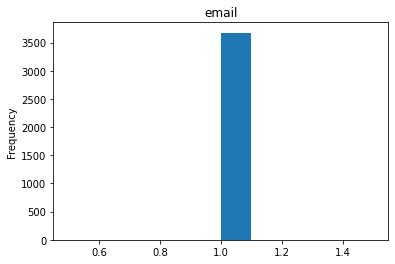

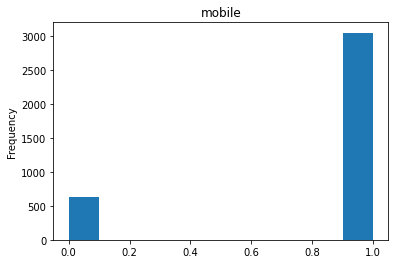

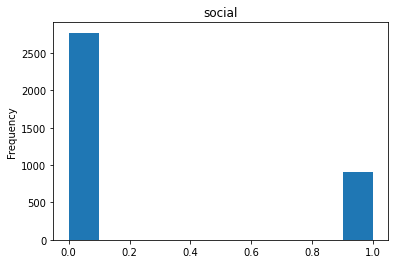

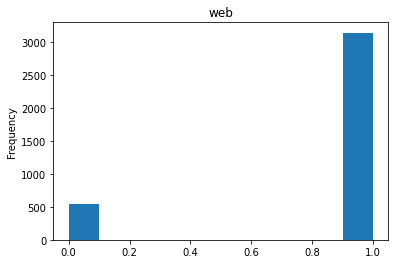

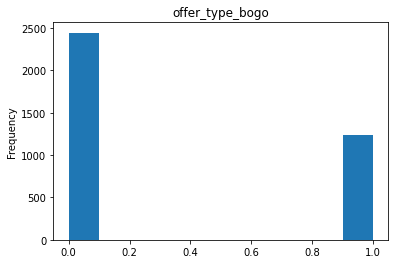

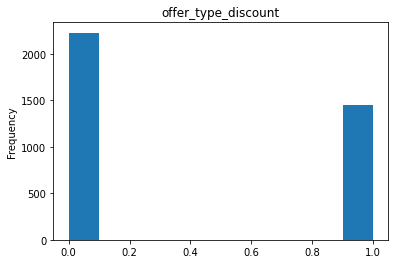

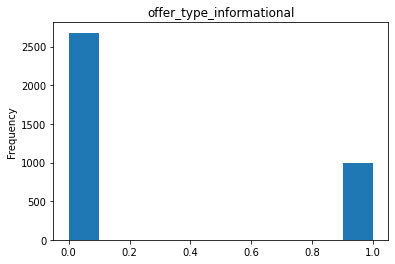

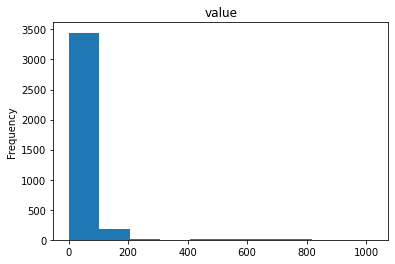

In [17]:
show_df_dist(wrongs)

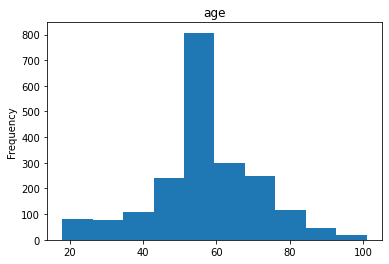

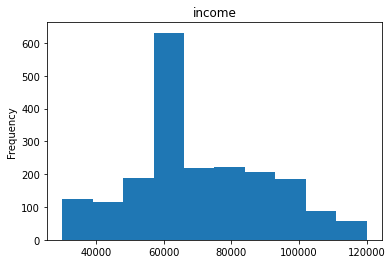

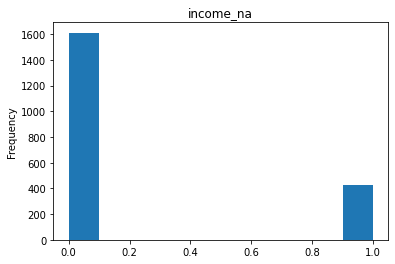

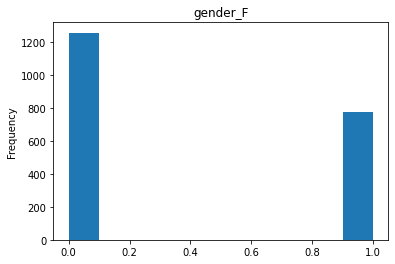

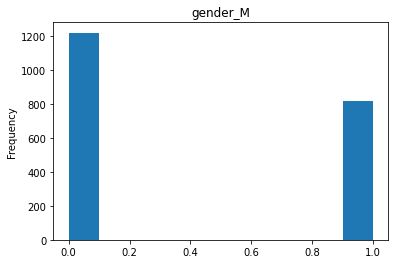

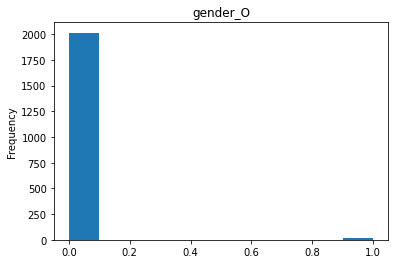

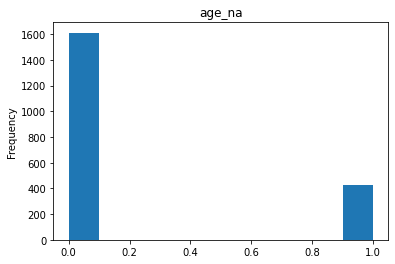

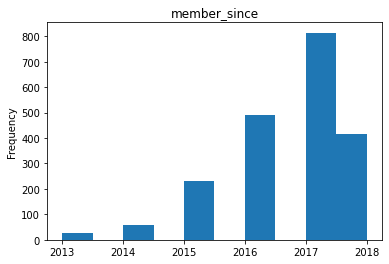

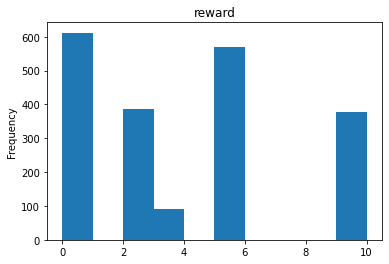

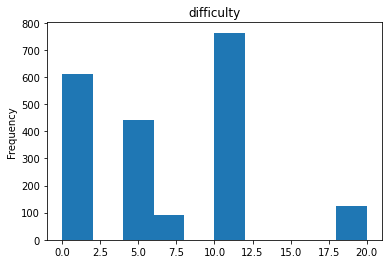

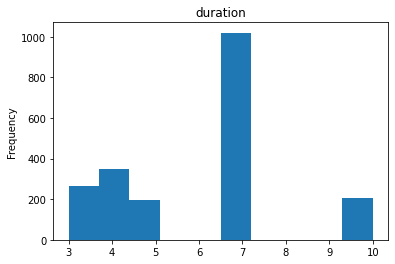

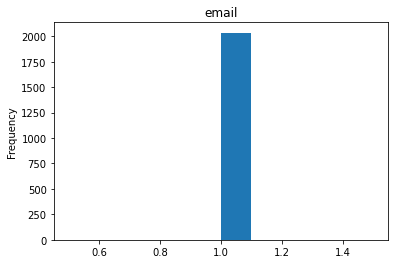

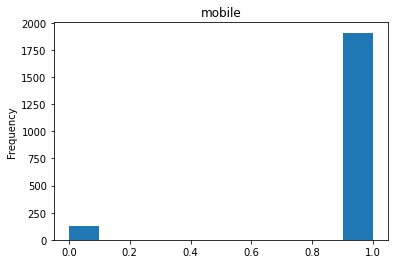

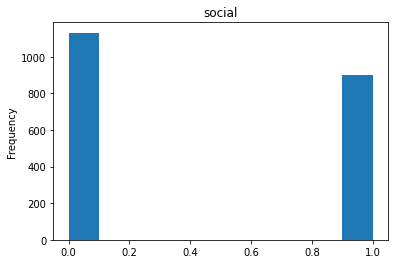

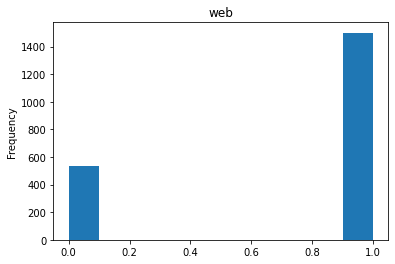

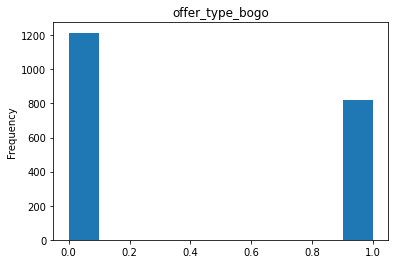

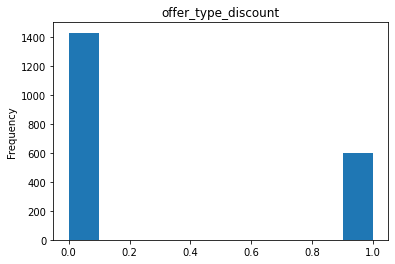

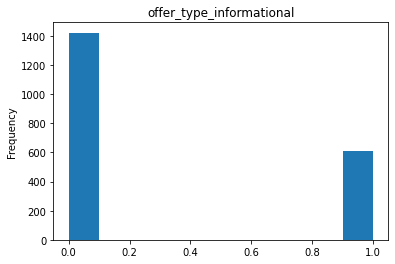

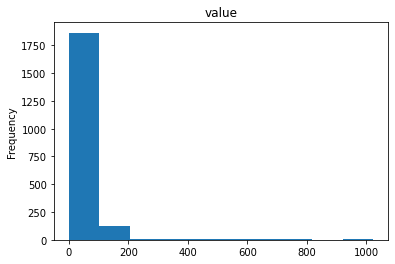

In [32]:
show_df_dist(test_fp)

<AxesSubplot:ylabel='Frequency'>

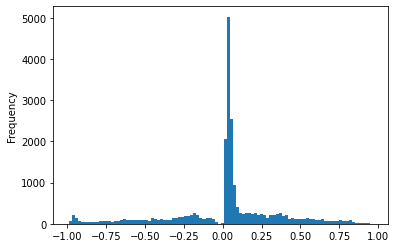

In [28]:
y_pred = model.predict_proba(X_test)[:, 1]
# error = y_test * (y_test - y_pred) + (1 - y_test) * (y_pred - y_test)
error = y_test - y_pred
error.plot.hist(bins=100)

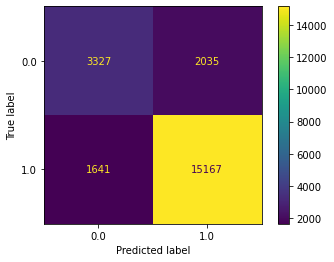

In [32]:
plot_confusion_matrix(model, X_test, y_test)

d:\programdata\anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


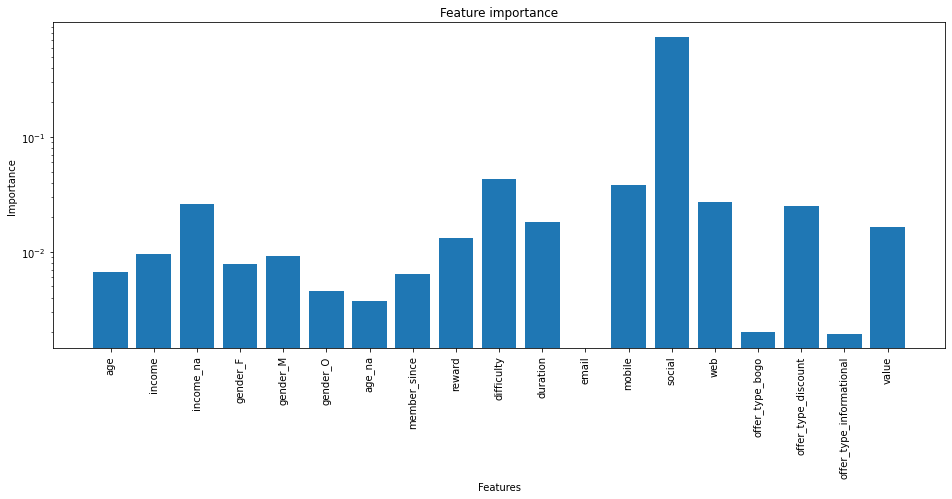

In [37]:
def plot_feature_importance(model, features):
    
    feature_importance = model.feature_importances_
    plt.figure(figsize=(16, 6))
    plt.yscale('log', nonposy='clip')
    plt.bar(range(len(feature_importance)), feature_importance, align='center')
    plt.xticks(range(len(feature_importance)), features, rotation='vertical')
    plt.title('Feature importance')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()
    
# model.named_steps['xgb']
plot_feature_importance(model.best_estimator_.named_steps['xgb'], X_test.columns)